# Clothing Image Classifier 
This notbook I build a clothing image classifier using A **fully connected nueral network** and the FashionMNIST dataset

In [26]:
# imports 
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

## Class appraoch 

In [27]:
# create transform 
transform = transforms.Compose([
    transforms.ToTensor(),      # convert to tensor 
    transforms.Normalize((0.5), (0.5))      # center data around 0 for faster and stable learning  
                                            # This normalizes the single chanel being worked with
])

Normalize((0.5,), (0.5,)) line performs this math:$$output = \frac{input - 0.5}{0.5}$$
- If the pixel is 0.0 (black): $(0.0 - 0.5) / 0.5 = \mathbf{-1.0}$
- If the pixel is 1.0 (white): $(1.0 - 0.5) / 0.5 = \mathbf{1.0}$

Data is now centered around 0.

## Create Datasets and Data Loaders

In [28]:
# datasets
trainset = torchvision.datasets.FashionMNIST('./data', download=True, train=True, 
                                             transform=transform)
testset = torchvision.datasets.FashionMNIST('./data', download=True, train=False, 
                                            transform=transform)

# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=30, 
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=30, 
                                         shuffle=False, num_workers=2)

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

## Classes 

In [29]:
# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

## Check DataLoader Output 

Batch shape: torch.Size([30, 1, 28, 28])
Pullover | Bag | Trouser | Sandal | Shirt | Shirt | Shirt | Trouser | Coat | Sneaker | Coat | Sandal | Pullover | Sandal | Sneaker | Ankle Boot | Ankle Boot | Sandal | Shirt | Sneaker | T-shirt/top | Trouser | Ankle Boot | Dress | Coat | Ankle Boot | T-shirt/top | Pullover | Sneaker | Sandal


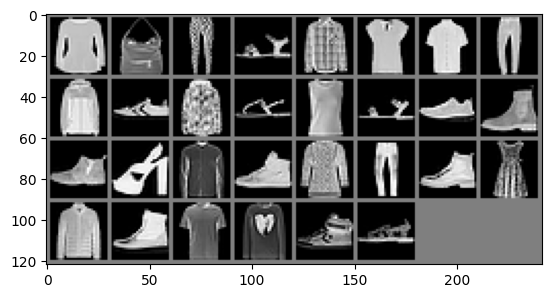

In [30]:
# show img function 

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # (C, H, W) -> (H, W, C)

# get image batch from trai data 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# check the shape 
print(f'Batch shape: {images.shape}') # should be [30, 1, 28, 28] [batch_size, channels, H, W]

# show images and labels
imshow(torchvision.utils.make_grid(images))
print(' | '.join(f'{classes[labels[i]]}' for i in range(len(labels))))

## Create Model 

In [31]:
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        # linear layers
        self.fc1 = nn.Linear(28 * 28, 1024)
        self.fc2 = nn.Linear(1024, 10) # output layer
    
    def forward(self, x): 
        # pass the image through Fully connected layers
        
        # flatten
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

fcn = FCN()    

## Loss function and Back Prop. Optimizer

In [32]:
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(fcn.parameters(), lr=0.001, momentum=0)

## Train Model 

In [33]:
for epoch in range(30):
    running_loss = 0.0 
    print_interval = 400
    for i, data in enumerate(trainloader, 0):
        
        inputs, labels = data
        optimizer.zero_grad()
        
        # forward pass
        outputs = fcn(inputs)
        loss = criterion(outputs, labels)
        
        # # back prop
        loss.backward()
        optimizer.step()
        
        # print running stats
        running_loss += loss.item()
        if i % print_interval == print_interval - 1:
            avg_loss = running_loss / print_interval
            print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] loss: {avg_loss:.3f}')
            running_loss = 0.0 

[Epoch 1, Batch   400] loss: 1.832
[Epoch 1, Batch   800] loss: 1.271
[Epoch 1, Batch  1200] loss: 1.019
[Epoch 1, Batch  1600] loss: 0.889
[Epoch 1, Batch  2000] loss: 0.814
[Epoch 2, Batch   400] loss: 0.759
[Epoch 2, Batch   800] loss: 0.723
[Epoch 2, Batch  1200] loss: 0.692
[Epoch 2, Batch  1600] loss: 0.668
[Epoch 2, Batch  2000] loss: 0.660
[Epoch 3, Batch   400] loss: 0.635
[Epoch 3, Batch   800] loss: 0.630
[Epoch 3, Batch  1200] loss: 0.606
[Epoch 3, Batch  1600] loss: 0.593
[Epoch 3, Batch  2000] loss: 0.598
[Epoch 4, Batch   400] loss: 0.587
[Epoch 4, Batch   800] loss: 0.576
[Epoch 4, Batch  1200] loss: 0.553
[Epoch 4, Batch  1600] loss: 0.563
[Epoch 4, Batch  2000] loss: 0.551
[Epoch 5, Batch   400] loss: 0.547
[Epoch 5, Batch   800] loss: 0.546
[Epoch 5, Batch  1200] loss: 0.537
[Epoch 5, Batch  1600] loss: 0.529
[Epoch 5, Batch  2000] loss: 0.520
[Epoch 6, Batch   400] loss: 0.523
[Epoch 6, Batch   800] loss: 0.513
[Epoch 6, Batch  1200] loss: 0.513
[Epoch 6, Batch  160

# Test Model 

In [34]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        
        images, labels = data
        
        # raw model scores
        outputs = fcn(images)
        # extract highest score
        _, predicted = torch.max(outputs.data, 1)
        # count total images processes so far
        total += labels.size(0)
        # count how many in this batch matches the labels
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total 
print(f'Final accuracy on {total} test images: {accuracy:.1f}%')

Final accuracy on 10000 test images: 84.8%
